# Imports

In [174]:
import pandas as pd
import os
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Open data

In [195]:
data = pd.read_table("data/welddb.data",sep = " ", header=None)

# Preprocessing

In [196]:
data.replace('N', None, inplace=True)
data.columns = ["C concentration (weight%)","Si concentration (weight%)", "Mn concentration (weight%)","S concentration (weight%)", "P concentration (weight%)", "Ni concentration (weight%)", "Cr concentration (weight%)", "Mo concentration (weight%)", "V concentration (weight%)", "Cu concentration (weight%)", "Co concentration (weight%)", "W concentration (weight%)", "O concentration (ppm/weight)", "Ti concentration (ppm/weight)", "N concentration (ppm/weight)", "Al concentration (ppm/weight)", "B concentration (ppm/weight)", "Nb concentration (ppm/weight)", "Sn concentration (ppm/weight)", "As concentration (ppm/weight)", "Sb concentration (ppm/weight)", "Current (A)", "Voltage (V)", "AC or DC", "Electrode positive or negative", "Heat input (kJ/mm)", "Interpass temperature (deg C)", "Type of weld", "Post weld heat treatment temperature (deg C)", "Post weld heat treatment time (hours)", "Yield strength (MPa)", "Ultimate tensile strength (MPa)", "Elongation (%)", "Reduction of Area (%)", "Charpy temperature (deg C)", "Charpy impact toughness (J)", "Hardness (kg/mm2)", "50 FATT", "Primary ferrite in microstructure (%)", "Ferrite with second phase (%)", "Acicular ferrite (%)", "Martensite(%)", "Ferrite with carbide aggreagate (%)", "Weld ID"]
data = data.replace("<","",regex=True)
data['N concentration (ppm/weight)'] = data['N concentration (ppm/weight)'].str.split("tot").str[0]
data['Hardness (kg/mm2)'] = data['Hardness (kg/mm2)'].str.split("(").str[0]
data['Hardness (kg/mm2)'] = data['Hardness (kg/mm2)'].str.split("H").str[0]
data['Interpass temperature (deg C)'] = data['Interpass temperature (deg C)'].replace('150-200','175')
for i, column in enumerate(data.columns):
    if i not in [23,24,27,43]:
        data[column] = data[column].astype(float)

data.columns = data.columns.map(str)

In [197]:
data['AC or DC']

0         DC
1         DC
2         DC
3         DC
4         DC
        ... 
1647    None
1648    None
1649    None
1650    None
1651    None
Name: AC or DC, Length: 1652, dtype: object

# Missing values analysis

## Missing values matrix

<Axes: >

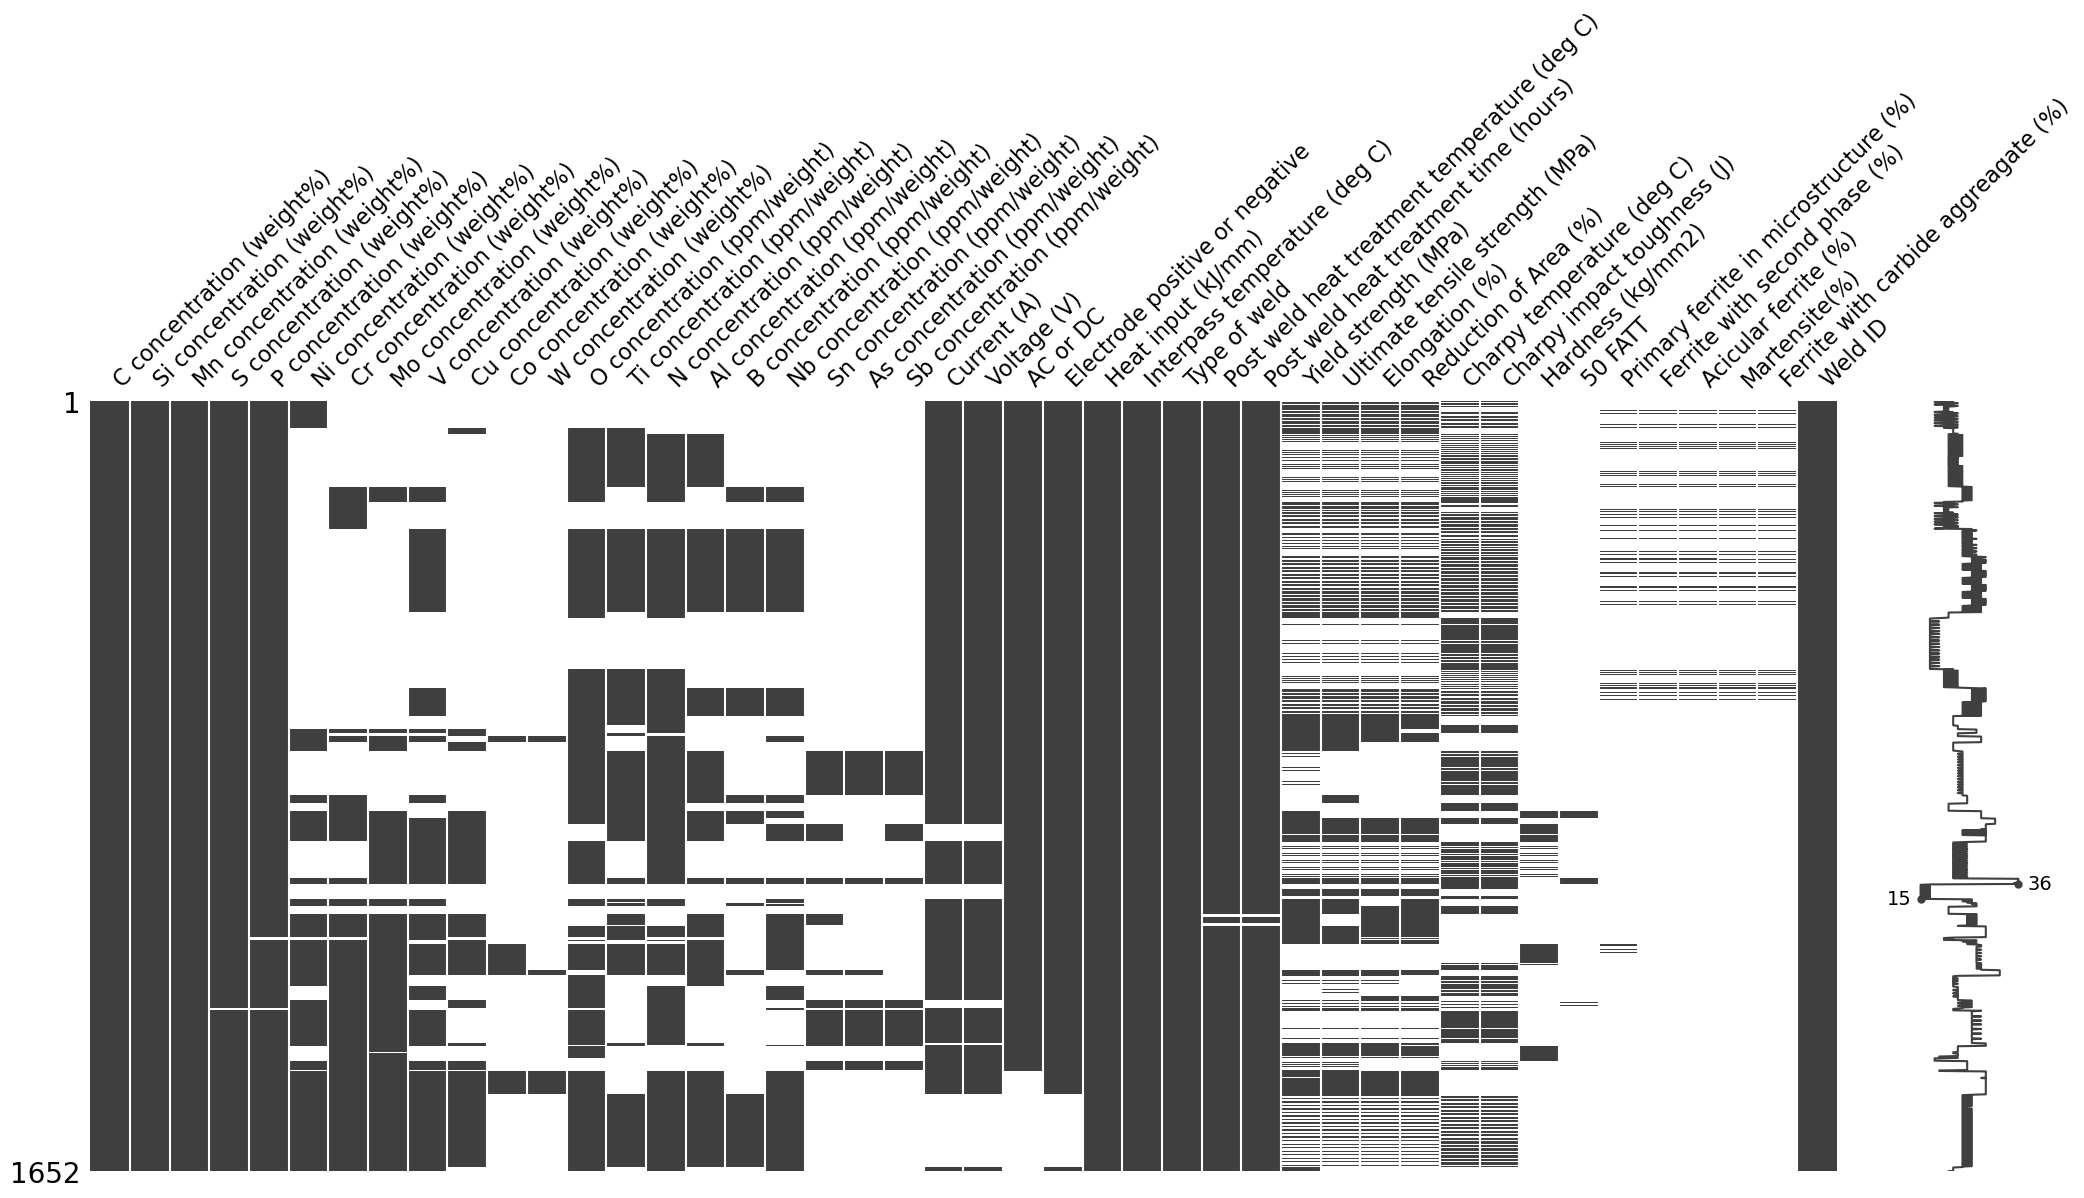

In [198]:
msno.matrix(data)

### Analyse:

Grace à cette matrice, on voit que certaines concentrations sont très souvent mesurées, alors que d'autres le sont beaucoup moins. On relève également que certaines variables ont énormément de valeurs manquantes, et qu'on pourra donc les éliminer. De plus, on constate que deux types de tests sont réalisés pour évaluer la qualité des soudures:

<Axes: >

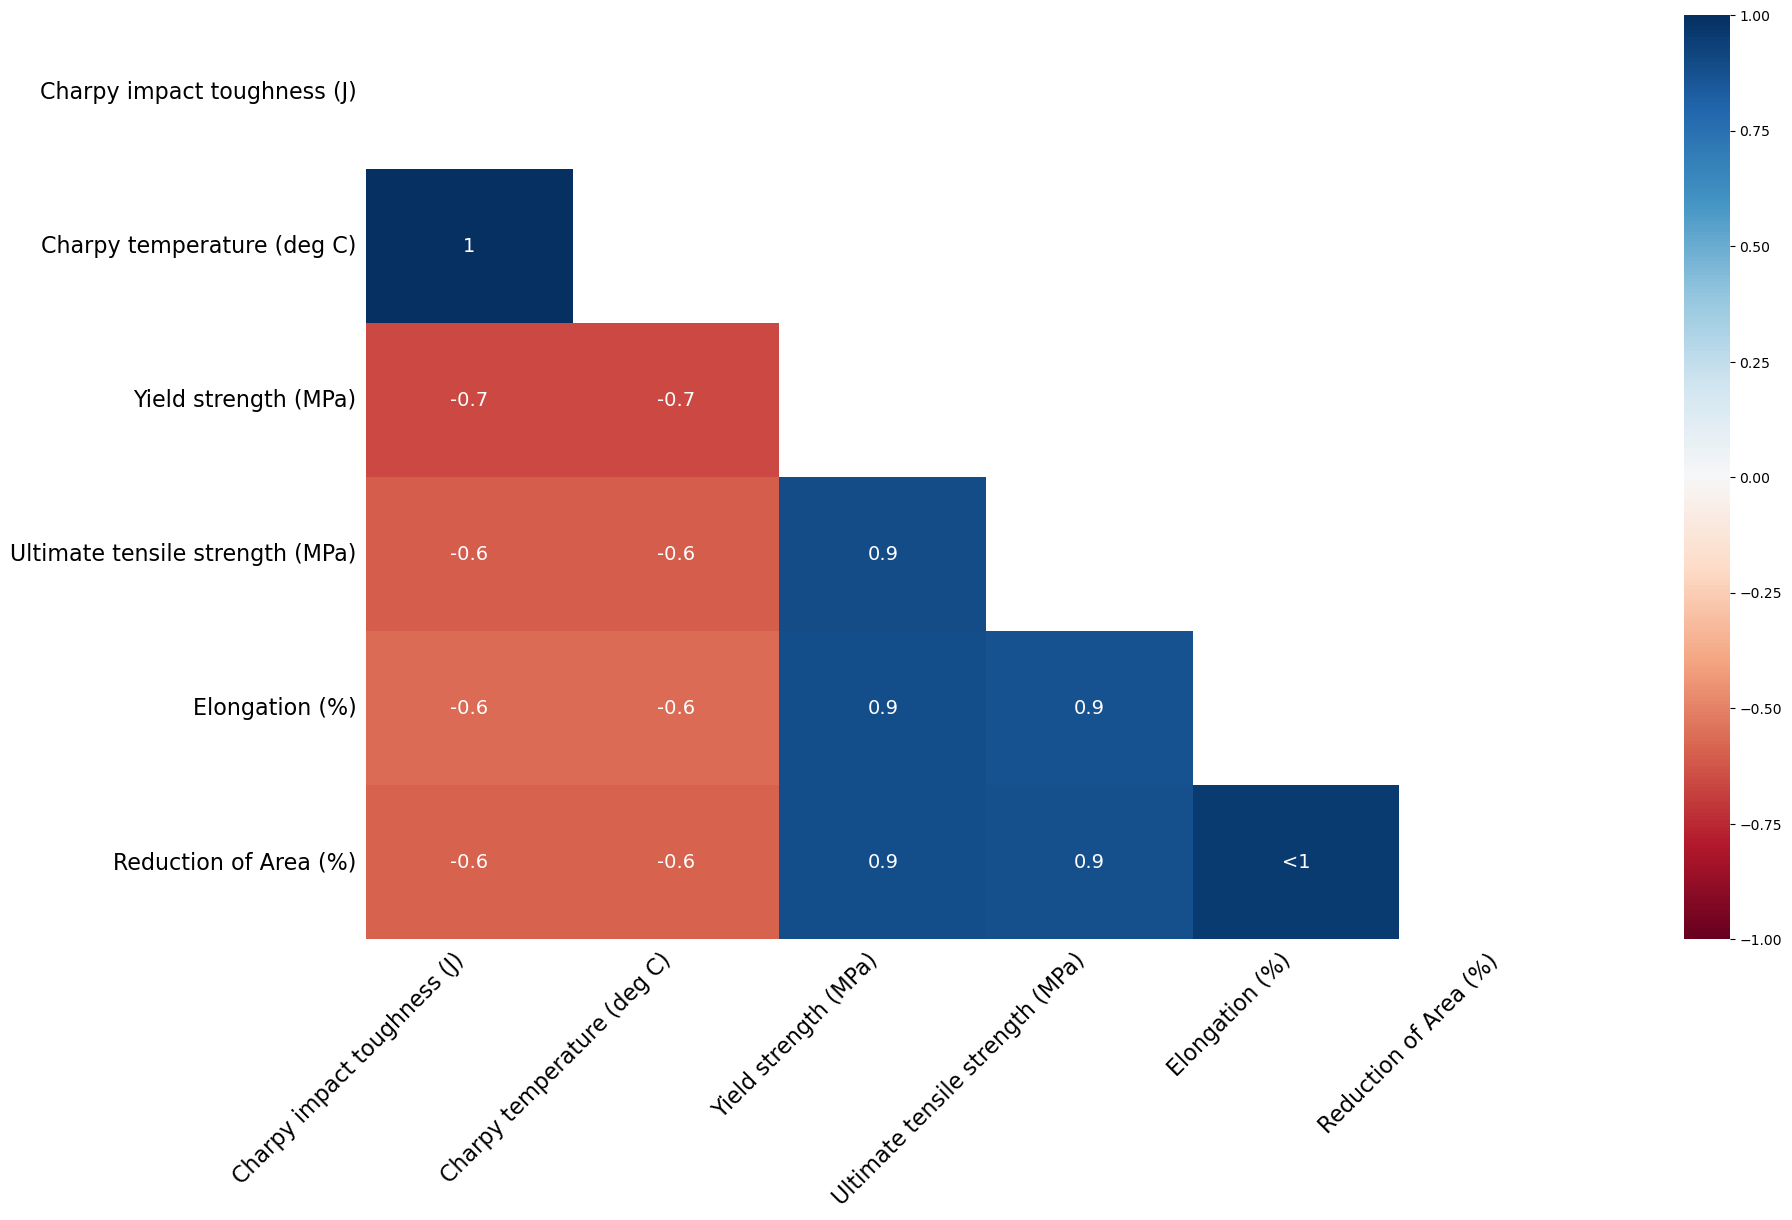

In [199]:
charpy_columns = ["Charpy impact toughness (J)", "Charpy temperature (deg C)"]
stress_columns = ["Yield strength (MPa)", "Ultimate tensile strength (MPa)", "Elongation (%)", "Reduction of Area (%)"]
target_columns = charpy_columns + stress_columns
msno.heatmap(data[charpy_columns + stress_columns])

In [204]:
kept_cols = [elem for elem in data.columns if elem not in target_columns]

On remarque que de manière générale, on va effectuer un test ou l'autre

<Axes: >

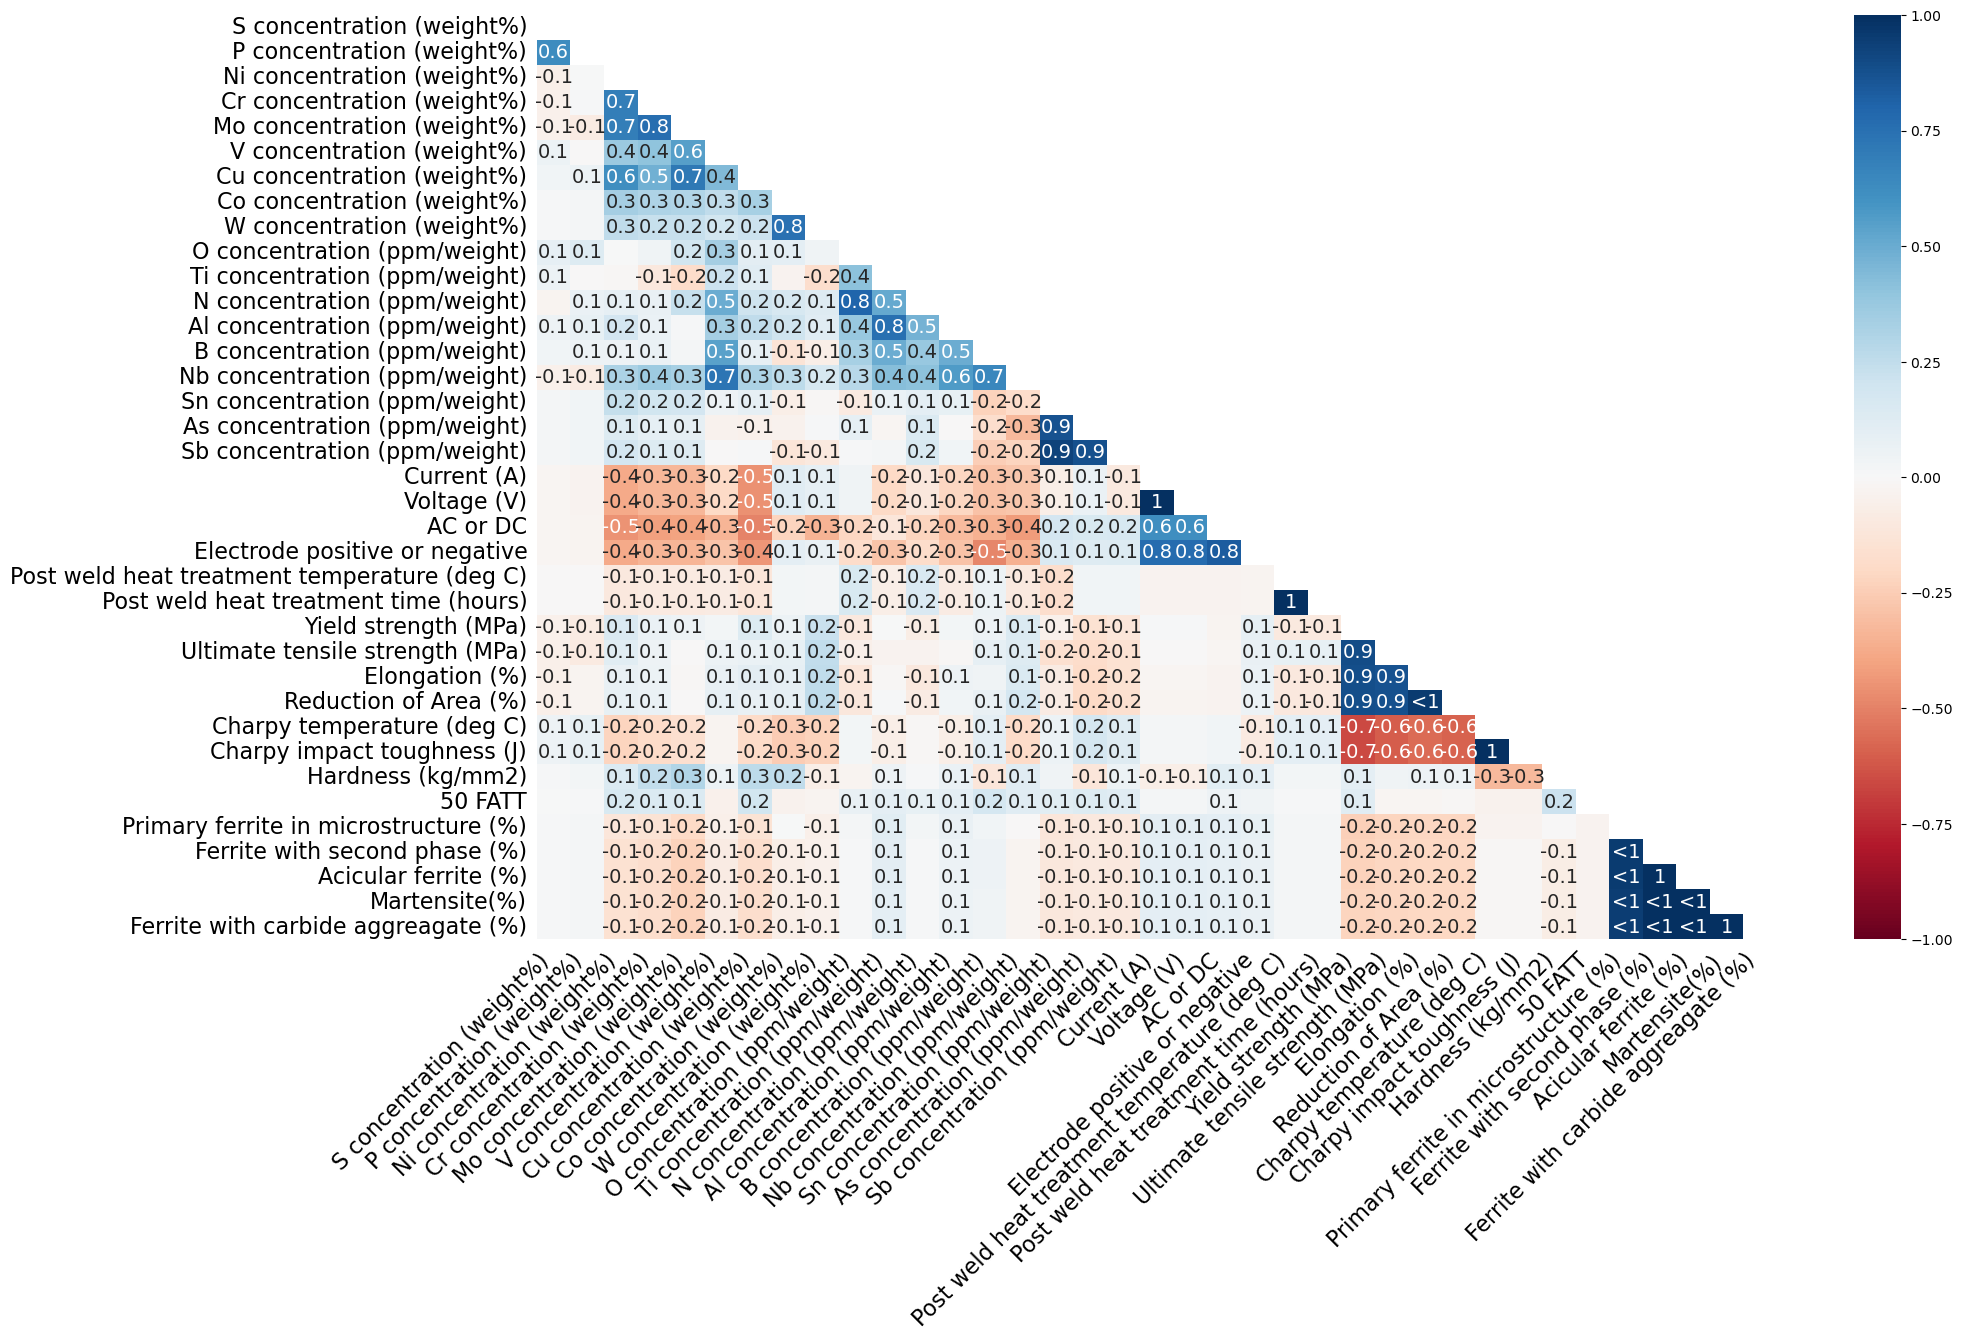

In [203]:
msno.heatmap(data)

on ne remarque pas spécialement d'autres corrélations importantes en terme de valeurs manquantes

## Suppression des colonnes avec des taux importants de valeurs manquantes

In [205]:
#data_comp = data.dropna(axis=1,thresh=int(0.4 * len(data)),subset=data.columns)
non_null_counts = data[kept_cols].notna().sum()
columns_to_drop = non_null_counts[non_null_counts < 0.5*len(data)].index.tolist()
data_comp = data.drop(columns=columns_to_drop)
data_comp = data_comp.dropna(axis=0,thresh=int(0.7 * len(data_comp.columns)))
data_comp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1463 entries, 0 to 1650
Data columns (total 26 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   C concentration (weight%)                     1463 non-null   float64
 1   Si concentration (weight%)                    1463 non-null   float64
 2   Mn concentration (weight%)                    1463 non-null   float64
 3   S concentration (weight%)                     1459 non-null   float64
 4   P concentration (weight%)                     1453 non-null   float64
 5   V concentration (weight%)                     921 non-null    float64
 6   O concentration (ppm/weight)                  1243 non-null   float64
 7   Ti concentration (ppm/weight)                 929 non-null    float64
 8   N concentration (ppm/weight)                  1226 non-null   float64
 9   Al concentration (ppm/weight)                 899 non-null    float6

<Axes: >

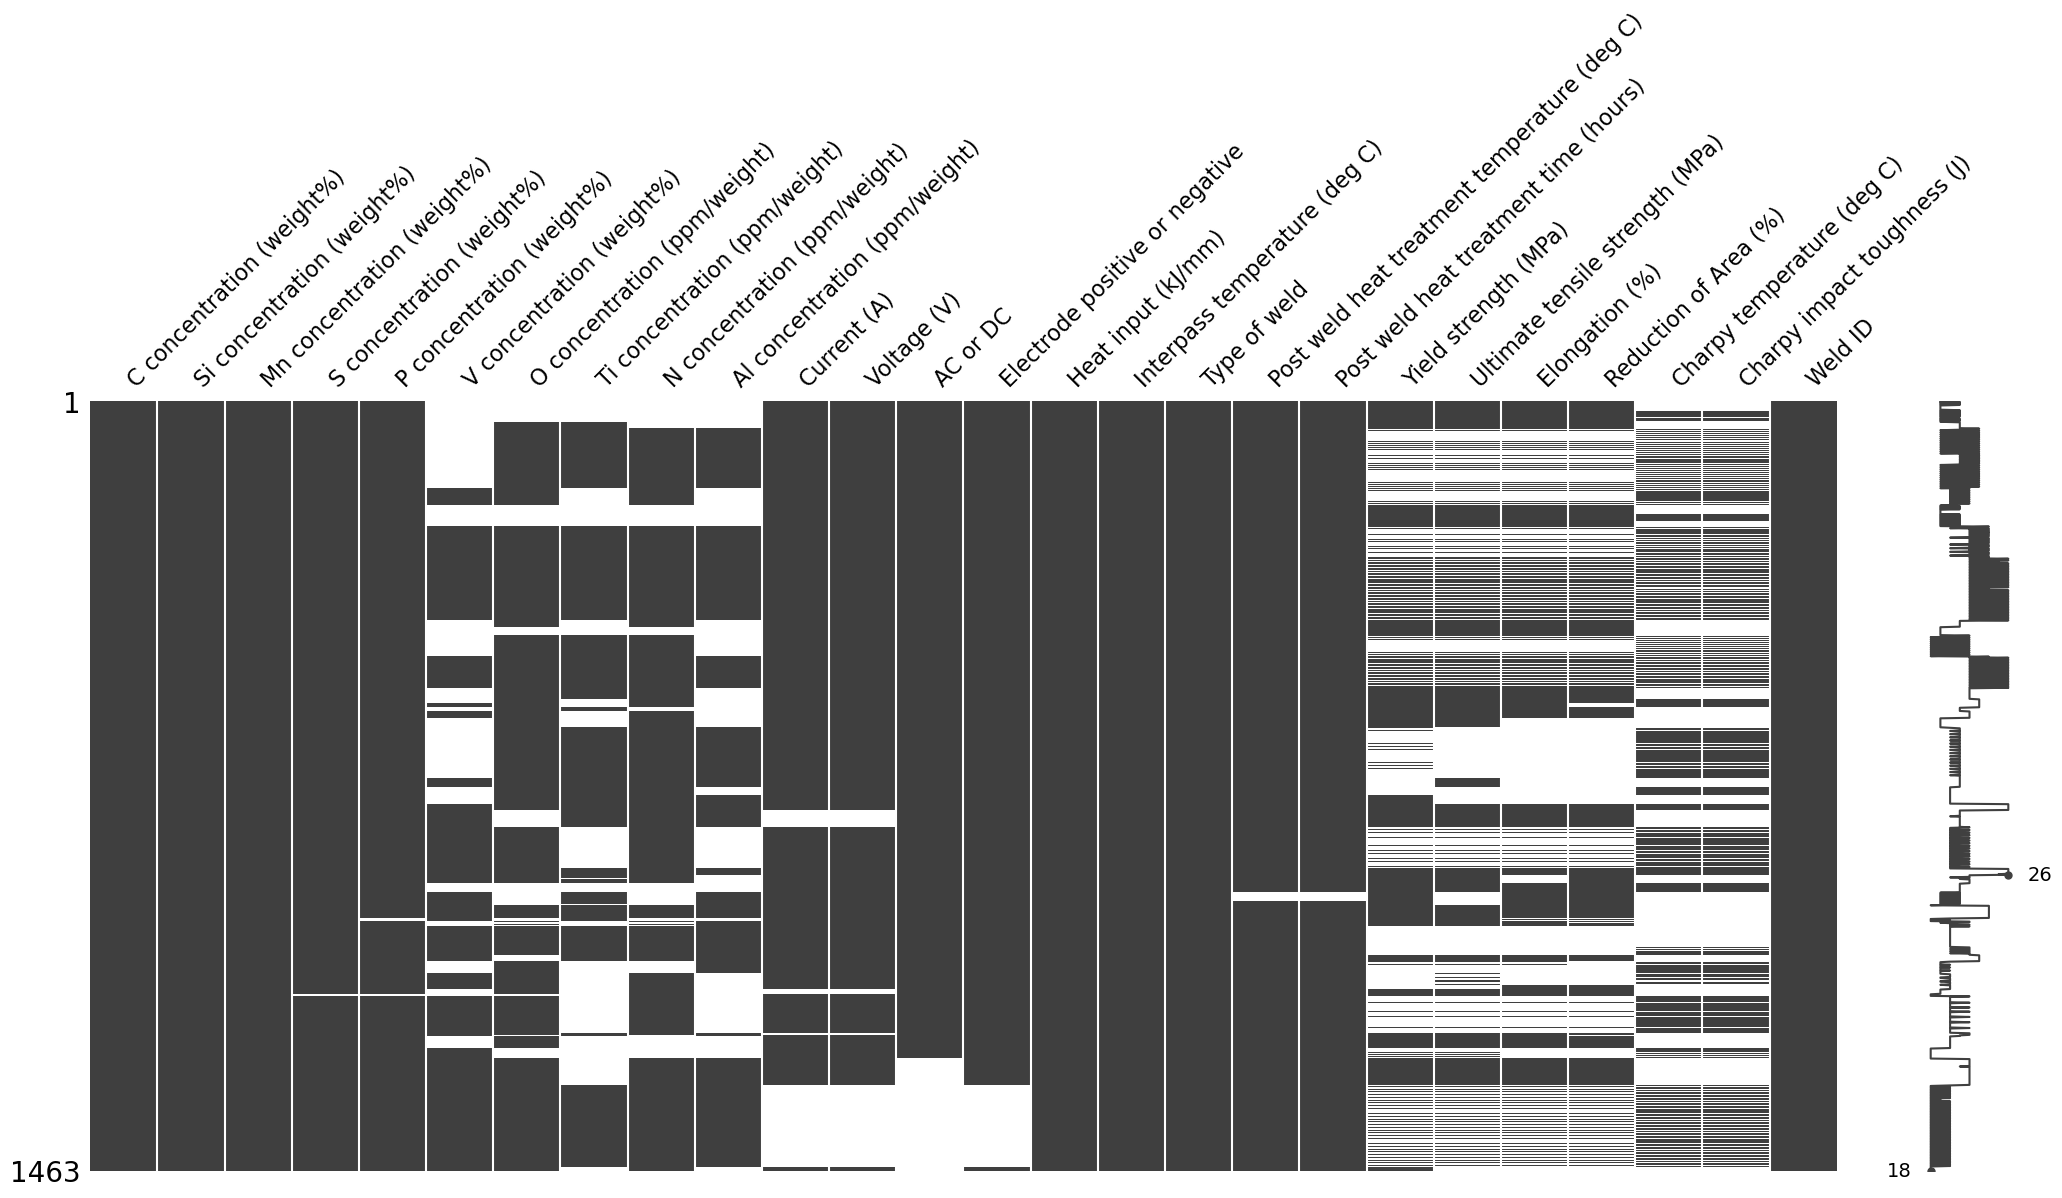

In [206]:
msno.matrix(data_comp)

We also drop the Weld ID column since it has no incidence on the quality

In [207]:
data_comp.drop(columns=["Weld ID"],inplace=True)

# Normalization

In [216]:
data_numeric = data_comp.select_dtypes(include=['Float64'])
string_cols = data_comp.select_dtypes(include=[object])
numeric_cols_z_score_normalized = (data_numeric - data_numeric.mean()) / data_numeric.std()
data_normalized = pd.concat([numeric_cols_z_score_normalized, string_cols], axis=1)


<Axes: >

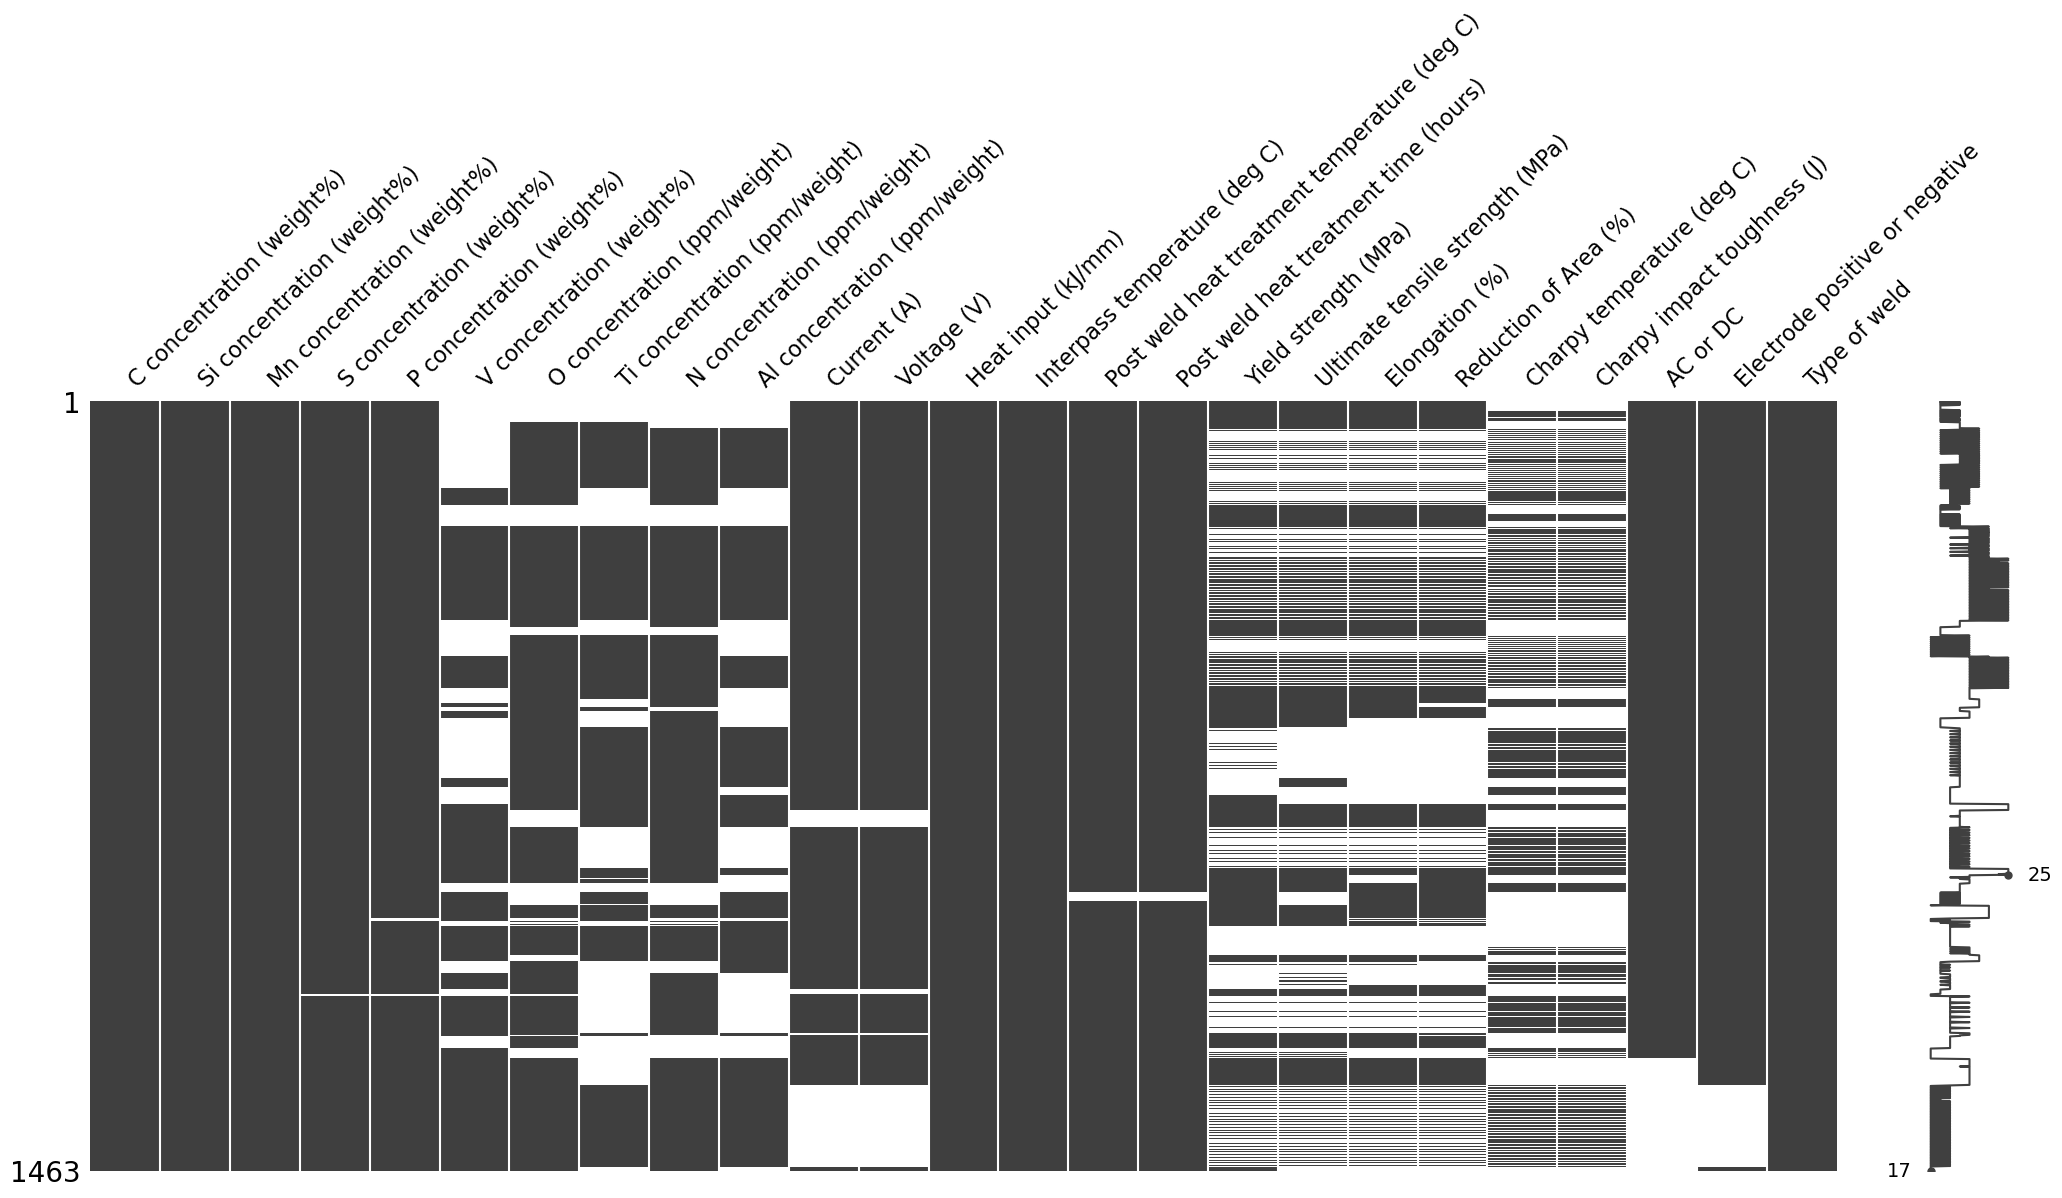

In [209]:
msno.matrix(data_normalized)

## changing the categorical data into binary one

In [217]:
data_normalized['AC'] = data_normalized['AC or DC'].apply(lambda x: True if x == 'AC' else False)
data_normalized = data_normalized.drop('AC or DC', axis=1)

data_normalized['electrode positive'] = data_normalized['Electrode positive or negative'].apply(lambda x: False if x == '-' else True)
data_normalized = data_normalized.drop('Electrode positive or negative', axis=1)

# One hot encoding of the type of weld

In [218]:
data_final = pd.get_dummies(data_normalized, columns=['Type of weld'], drop_first=True)
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1463 entries, 0 to 1650
Data columns (total 33 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   C concentration (weight%)                     1463 non-null   float64
 1   Si concentration (weight%)                    1463 non-null   float64
 2   Mn concentration (weight%)                    1463 non-null   float64
 3   S concentration (weight%)                     1459 non-null   float64
 4   P concentration (weight%)                     1453 non-null   float64
 5   V concentration (weight%)                     921 non-null    float64
 6   O concentration (ppm/weight)                  1243 non-null   float64
 7   Ti concentration (ppm/weight)                 929 non-null    float64
 8   N concentration (ppm/weight)                  1226 non-null   float64
 9   Al concentration (ppm/weight)                 899 non-null    float6

### Filling residual missing values with mean values

In [221]:
kept_cols = [elem for elem in data_final.columns if elem not in target_columns]
for col in kept_cols:
    data_final[col] = data_final[col].fillna(data_final[col].mean())

<Axes: >

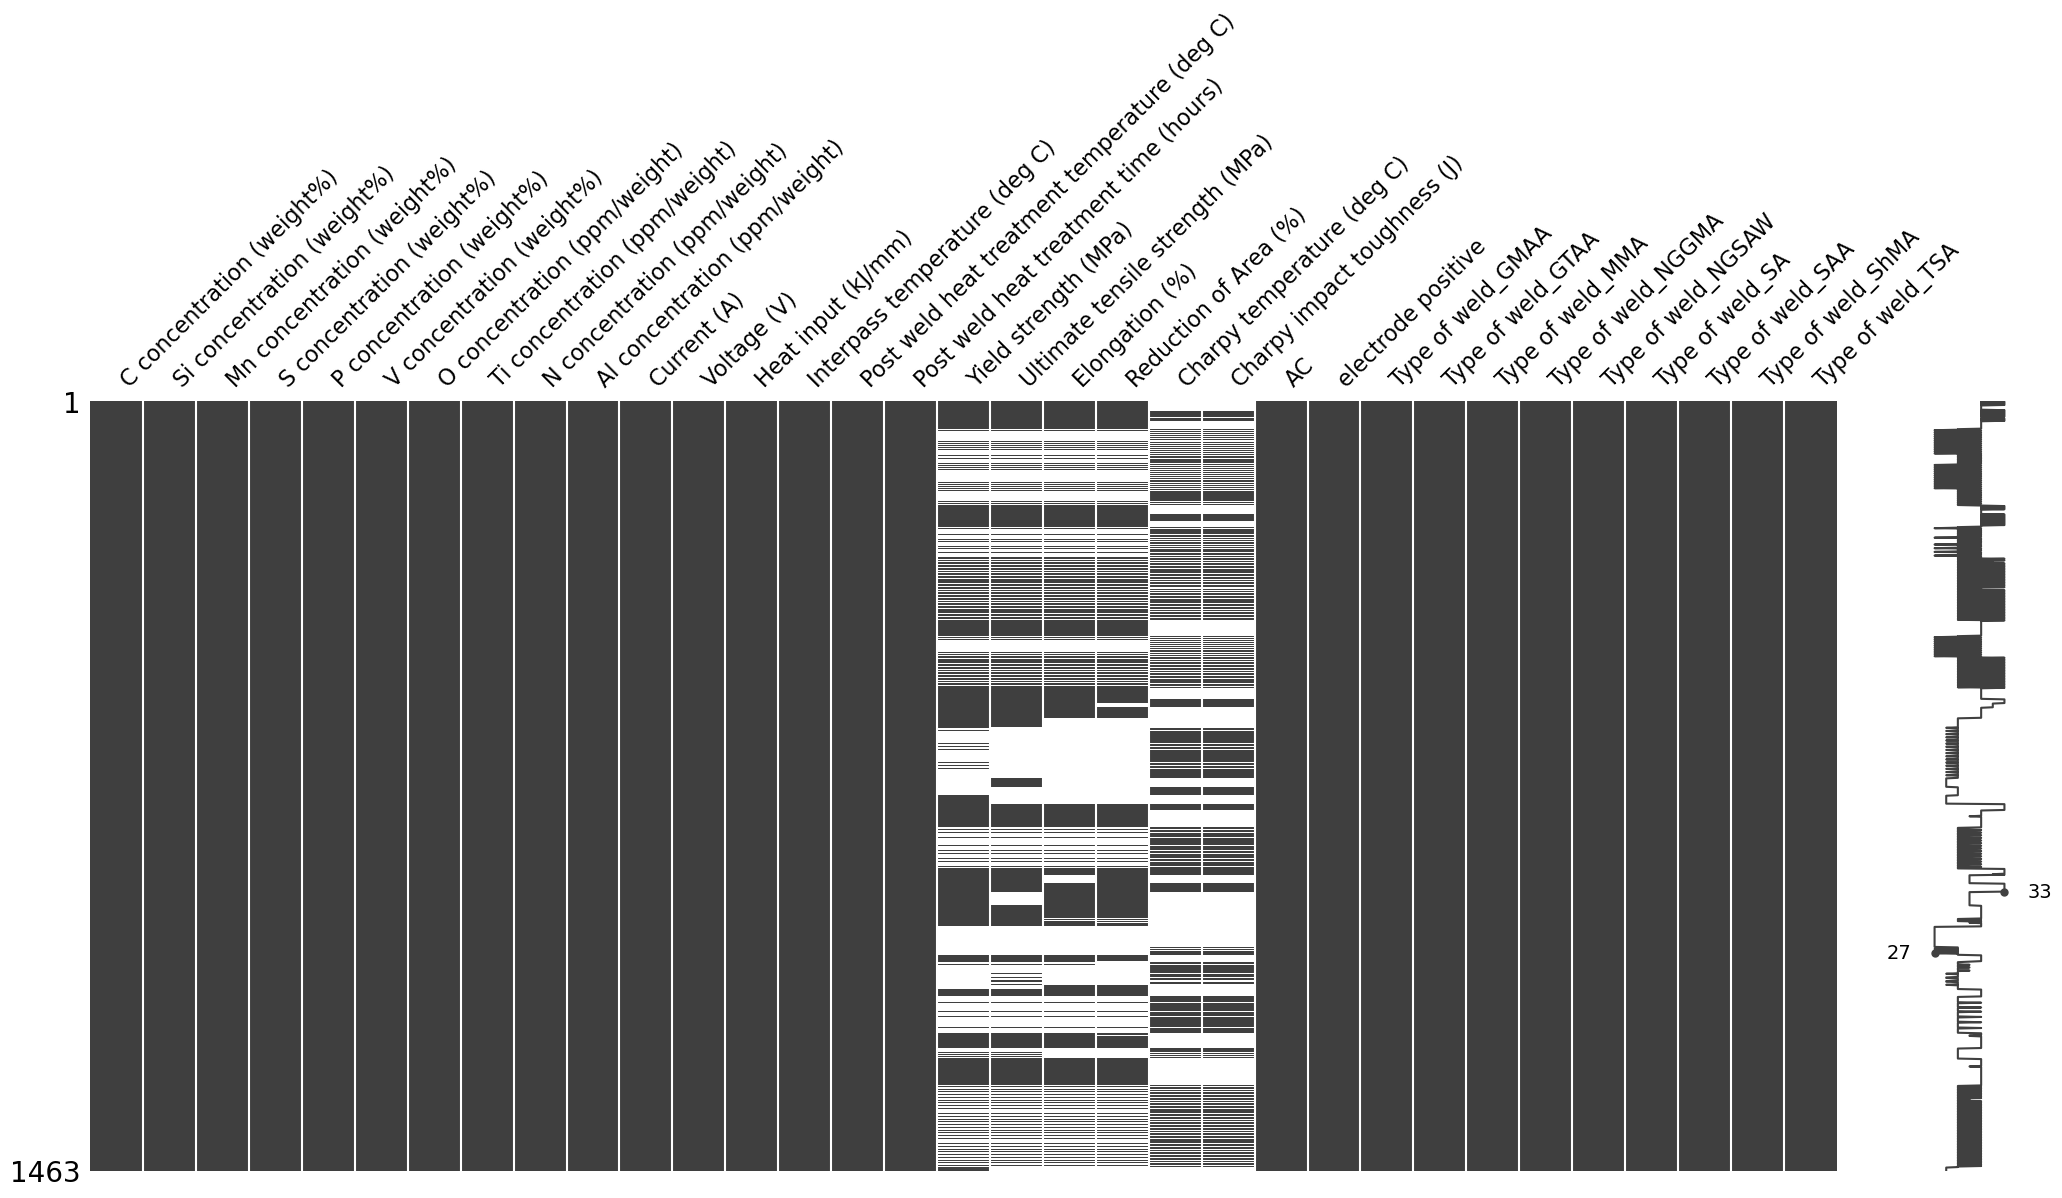

In [222]:
msno.matrix(data_final)

In [223]:
data_final.to_csv('preprocessed_data.csv',index=False)